# CS 585 Problem Set 2 (Total points: 95)

Assignment adapted from Svetlana Lazebnik.

**Instructions**
1.   Assignment is due at 11:59 PM on Tuesday March 04 2025.
2.   Submission instructions:

     A. A single .pdf report that contains your work for Q1 and Q2. You can either type out your responses in LaTeX or google document. Lastly, please convert your work into a PDF.

       The PDF file should be submitted to Gradescope under PS2. Please tag the reponses in your PDF with the Gradescope questions outline as described in Submitting an Assignment.

     B. You also need to submit your code in the form of a single .py file in the same directory. You can convert this notebook to Python code by downloading the .ipynb file as Python(.py). Code should also be submitted to Gradescope under PS2-Code. Not submitting your code will lead to a loss of 100% of the points for implementation.

     C. Both Q1 and Q2 require you to evaluate your implemented models on held-out test data. You will need to submit the generated outputs ("Q1_label_predictions.npy" and "Q2_surface_predictions.npy") in the PS2-Code directory as well.

     D. We reserve the right to take off points for not following submission instructions. In particular, please tag the reponses in your PDF with the Gradescope questions outline as described in [Submitting an Assignment](https://www.youtube.com/watch?v=u-pK4GzpId0).
   

#**Q1: Cifar-10 class predictions**

# Mount Google Drive

This will allow the Colab machine to access Google Drive folders by mounting the drive on the machine. You may be asked to copy and paste an authentication code.

In [25]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [26]:
!ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


# Change directory to allow imports


As noted above, you should create a Google Drive folder to hold all your assignment files. You will need to add this code to the top of any python notebook you run to be able to import python files from your drive assignment folder (you should change the file path below to be your own assignment folder).

In [1]:
import os
if not os.path.exists("/projectnb/cs585bp/students/xananya/CS_585_PS2"):
    os.makedirs("/projectnb/cs585bp/students/xananya/CS_585_PS2")
os.chdir("/projectnb/cs585bp/students/xananya/CS_585_PS2")

In [2]:
!ls # Check if this is your PS2 folder

CS585_PS2.ipynb		    data
Q1_label_predictions.npy    indoor
Q2_surface_predictions.npy  q2_visualization.pdf
__MACOSX		    taskonomy_resize_128_public
best_normal_model.pth	    taskonomy_resize_128_public.zip
content			    vis_valset.pdf


# Set up GPU and PyTorch

First, ensure that your notebook on Colaboratory is set up to use GPU. After opening the notebook on Colaboratory, go to Edit>Notebook settings, select Python 3 under "Runtime type," select GPU under "Hardware accelerator," and save.

Next, install PyTorch:

In [3]:
!pip3 install torch torchvision

Defaulting to user installation because normal site-packages is not writeable


Make sure that pytorch is installed and works with GPU:

In [4]:
import torch
a = torch.Tensor([1]).cuda()
print(a)


tensor([1.], device='cuda:0')


In [5]:
torch.cuda.is_available()

True

In [6]:
# imports and useful functions

from __future__ import print_function
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
import copy
import csv
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path
from tqdm.notebook import tqdm
import sys
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

np.random.seed(111)
torch.cuda.manual_seed_all(111)
torch.manual_seed(111)


class CIFAR10Test(torchvision.datasets.VisionDataset):
    def __init__(self, root, transform=None,
    ):
        super(CIFAR10Test, self).__init__(root, transform=transform)

        image_filename = os.path.join(root, 'cifar10_test_images.npy')
        images = np.load(image_filename)

        assert len(images.shape) == 4
        assert images.shape[0] == 2000
        assert images.shape[1] == 32
        assert images.shape[2] == 32
        assert images.shape[3] == 3

        self.data = images

    def __getitem__(self, index):
        img = self.data[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.data)


def calculate_accuracy(dataloader, model, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        dataloader (torch.utils.data.DataLoader): val set
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """
    correct = 0.
    total = 0.
    predictions = []

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))

    # Check out why .eval() is important!
    # https://discuss.pytorch.org/t/model-train-and-model-eval-vs-model-and-model-eval/5744/2
    model.eval()

    with torch.no_grad():
      for data in dataloader:
          images, labels = data
          if is_gpu:
              images = images.cuda()
              labels = labels.cuda()
          outputs = model(Variable(images))
          _, predicted = torch.max(outputs.data, 1)
          predictions.extend(list(predicted.cpu().numpy()))
          total += labels.size(0)
          correct += (predicted == labels).sum()

          c = (predicted == labels).squeeze()
          for i in range(len(labels)):
              label = labels[i]
              class_correct[label] += c[i].cpu()
              class_total[label] += 1

    class_accuracy = 100 * np.divide(class_correct, class_total)
    return 100*correct/total, class_accuracy


def run_secret_test(dataloader, model, is_gpu):
    predictions = []
    model.eval()

    with torch.no_grad():
      for images in dataloader:
          if is_gpu:
              images = images.cuda()
          outputs = model(Variable(images))
          predicted = torch.softmax(outputs, dim=1).cpu().numpy()
          predictions.extend(list(predicted))

    return predictions



Training an image classifier
----------------------------

We will do the following steps in order:

1. Load the randomized CIFAR10 training, validation and test datasets using
   torchvision. Use torchvision.transforms to apply transforms on the
   dataset.
2. Define a Convolution Neural Network - BaseNet
3. Define a loss function and optimizer
4. Train the network on training data and check performance on val set.
   Plot train loss and validation accuracies.
5. Try the network on test data and create .npy file for submission to Gradescope

In [7]:
import os
print(os.getcwd())

/projectnb/cs585bp/students/xananya/CS_585_PS2


In [8]:
# <<TODO>>: Based on the val set performance, decide how many
# epochs are apt for your model.
# ---------
EPOCHS = 20
# ---------

IS_GPU = True
TEST_BS = 256
TOTAL_CLASSES = 10
TRAIN_BS = 32
PATH_TO_CIFAR10 = "data/cifar10/"
PATH_TO_CIFAR10_TEST = "data/cifar10/cifar10-test"

1.**Loading CIFAR-10**

We will load the CIFAR-10 dataset with builtin dataset loader from Torchvision. We also created our own train, validation and test splits. You can download them using this link: https://drive.google.com/drive/folders/1qmfLQ8hso5qrN9kyobmKKiCl0PWBdLhK?usp=sharing . Upload the file to colab.

In [9]:
!unzip -qqo /content/cifar10_splits.zip

unzip:  cannot find or open /content/cifar10_splits.zip, /content/cifar10_splits.zip.zip or /content/cifar10_splits.zip.ZIP.


In [10]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# Using transforms.ToTensor(), transform them to Tensors of normalized range
# [-1, 1].

import torchvision.transforms as transforms
# <<TODO#1>> Use transforms.Normalize() with the right parameters to
# make the data well conditioned (zero mean, std dev=1) for improved training.
# <<TODO#2>> Try using transforms.RandomCrop() and/or transforms.RandomHorizontalFlip()
# to augment training data.
# After your edits, make sure that test_transform should have the same data
# normalization parameters as train_transform
# You shouldn't have any data augmentation in test_transform (val or test data is never augmented).
# ---------------------
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # Add rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Add color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

test_transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])
train_transform = transforms.Compose(
    [transforms.ToTensor()])
test_transform = transforms.Compose(
    [transforms.ToTensor()])
# ---------------------

#DO NOT CHANGE any line below
train_dataset = torchvision.datasets.CIFAR10(root=PATH_TO_CIFAR10, train=True, download=True, transform=train_transform)
val_dataset = torchvision.datasets.CIFAR10(root=PATH_TO_CIFAR10, train=False, download=False, transform=test_transform)
test_dataset = CIFAR10Test(root=PATH_TO_CIFAR10_TEST, transform=test_transform)

val_dataset.data = np.load("data/cifar10_val_images.npy")
val_dataset.targets = np.load("data/cifar10_val_labels.npy")
test_dataset.data = np.load("data/cifar10/cifar10-test/cifar10_test_images.npy")

print("train_dataset data shape: ", np.array(train_dataset.data).shape)
print("train_dataset labels shape: ", np.array(train_dataset.targets).shape)
print()
print("val_dataset data shape: ", np.array(val_dataset.data).shape)
print("val_dataset labels shape:", np.array(val_dataset.targets).shape)

# check for Dataloader function: https://pytorch.org/docs/stable/data.html
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BS, shuffle=True, num_workers=2, drop_last=True)  #DO NOT CHANGE
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False, num_workers=2, drop_last=False) #DO NOT CHANGE

# The 10 classes for FashionMNIST
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
train_dataset data shape:  (50000, 32, 32, 3)
train_dataset labels shape:  (50000,)

val_dataset data shape:  (8000, 32, 32, 3)
val_dataset labels shape: (8000,)


2.**Visualize CIFAR-10**

We will visualize some random images from the CIFAR-10 dataset.

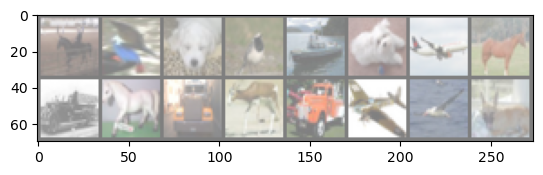

horse  bird   dog  bird  ship   dog airplane horse truck horse truck  deer truck airplane  bird   dog


In [11]:
# Let us show some of the training images, for fun.
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

3.**Define a Convolution Neural Network**

Implement the BaseNet exactly. BaseNet consists of two convolutional modules (conv-relu-maxpool) and two linear layers. The precise architecture is defined below:

| Layer No.   | Layer Type  | Kernel Size | Input Dim   | Output Dim  | Input Channels | Output Channels |
    | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
    | 1 | conv2d | 5 | 32 | 28 | 3 | 6 |
    | 2 | relu | - | 28 | 28 | 6 | 6 |
    | 3 | maxpool2d | 2 | 28 | 14 | 6 | 6 |
    | 4 | conv2d | 5 | 14 | 10 | 6 | 16 |
    | 5 | relu | - | 10 | 10 | 16 | 16 |
    | 6 | maxpool2d | 2 | 10 | 5 | 16 | 16 |
    | 7 | linear | - | 1 | 1 | 400 | 200 |
    | 8 | relu | - | 1 | 1 | 200 | 200 |
    | 9 | linear | - | 1 | 1 | 200 | 10 |

In [17]:
########################################################################
# We provide a basic network that you should understand, run and
# eventually improve
# <<TODO>> Add more conv layers
# <<TODO>> Add more fully connected (fc) layers
# <<TODO>> Add regularization layers like Batchnorm.
#          nn.BatchNorm2d after conv layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm2d
#          nn.BatchNorm1d after fc layers:
#          http://pytorch.org/docs/master/nn.html#batchnorm1d
# This is a good resource for developing a CNN for classification:
# http://cs231n.github.io/convolutional-networks/#layers

import torch.nn as nn
import torch.nn.functional as F

class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=256*4*4, out_features=1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(in_features=512, out_features=10)
        
    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.bn1_2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Second block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.bn2_2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Third block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.bn3_2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Flatten
        x = x.view(-1, 256*4*4)
        
        # Fully connected
        x = self.fc1(x)
        if x.shape[0] > 1:  # Only apply batchnorm if batch size > 1
            x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        if x.shape[0] > 1:
            x = self.bn5(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x

# Create an instance of the nn.module class defined above:
net = BaseNet()

# Test your BaseNet with some random input
dummy_input = torch.rand((1, 3, 32, 32))
output = net(dummy_input)
assert output.shape == torch.Size([1, 10])

# For training on GPU, we need to transfer net and data onto the GPU
# http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu
if IS_GPU:
    net = net.cuda()


In [18]:
# TODO: paste output in your report
print(net)

BaseNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

4.**Define a loss function and optimizer**

In [19]:
########################################################################
# Here we use Cross-Entropy loss and SGD with momentum.
# The CrossEntropyLoss criterion already includes softmax within its
# implementation. That's why we don't use a softmax in our model
# definition.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# Tune the learning rate.
# See whether the momentum and weight decay is useful or not
# Optimizer with higher initial learning rate
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

5.**Train the model**

In [20]:
########################################################################
# We simply have to loop over our data iterator, and feed the inputs to the
# network and optimize. We evaluate the validation accuracy at each
# epoch and plot these values over the number of epochs
# Nothing to change here
# -----------------------------
plt.ioff()
fig = plt.figure()
train_loss_over_epochs = []
val_accuracy_over_epochs = []

for epoch in tqdm(range(EPOCHS), total=EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        if IS_GPU:
            inputs = inputs.cuda()
            labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    # Normalizing the loss by the total number of train batches
    running_loss/=len(trainloader)
    print('[%d] loss: %.3f' %
          (epoch + 1, running_loss))

    # Scale of 0.0 to 100.0
    # Calculate validation set accuracy of the existing model
    val_accuracy, val_classwise_accuracy = \
        calculate_accuracy(valloader, net, IS_GPU)
    print('Accuracy of the network on the val images: %d %%' % (val_accuracy))

    scheduler.step()

    # # Optionally print classwise accuracies
    # for c_i in range(TOTAL_CLASSES):
    #     print('Accuracy of %5s : %2d %%' % (
    #         classes[c_i], 100 * val_classwise_accuracy[c_i]))

    train_loss_over_epochs.append(running_loss)
    val_accuracy_over_epochs.append(val_accuracy.cpu())
# -----------------------------


# Plot train loss over epochs and val set accuracy over epochs
# Nothing to change here
# -------------
plt.subplot(2, 1, 1)
plt.ylabel('Train loss')
plt.plot(np.arange(EPOCHS), train_loss_over_epochs, 'k-')
plt.title('train loss and val accuracy')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(EPOCHS, dtype=int))
plt.grid(True)
plt.savefig("content/mp4_q1_plot.png")
plt.close(fig)
print('Finished Training')
# -------------

  0%|          | 0/20 [00:00<?, ?it/s]

[1] loss: 1.183
Accuracy of the network on the val images: 67 %
[2] loss: 0.808
Accuracy of the network on the val images: 75 %
[3] loss: 0.613
Accuracy of the network on the val images: 79 %
[4] loss: 0.497
Accuracy of the network on the val images: 79 %
[5] loss: 0.395
Accuracy of the network on the val images: 81 %
[6] loss: 0.303
Accuracy of the network on the val images: 82 %
[7] loss: 0.227
Accuracy of the network on the val images: 83 %
[8] loss: 0.166
Accuracy of the network on the val images: 82 %
[9] loss: 0.120
Accuracy of the network on the val images: 83 %
[10] loss: 0.085
Accuracy of the network on the val images: 84 %
[11] loss: 0.060
Accuracy of the network on the val images: 83 %
[12] loss: 0.041
Accuracy of the network on the val images: 83 %
[13] loss: 0.029
Accuracy of the network on the val images: 84 %
[14] loss: 0.016
Accuracy of the network on the val images: 84 %
[15] loss: 0.010
Accuracy of the network on the val images: 84 %
[16] loss: 0.005
Accuracy of the n

6.**Evaluate the validation accuracy of your final model**

In [21]:
val_accuracy, val_classwise_accuracy = \
        calculate_accuracy(valloader, net, IS_GPU)
print('Accuracy of the final network on the val images: %.1f %%' % (val_accuracy))

# Optionally print classwise accuracies
for c_i in range(TOTAL_CLASSES):
    print('Accuracy of %5s : %.1f %%' % (
        classes[c_i], val_classwise_accuracy[c_i]))


Accuracy of the final network on the val images: 85.1 %
Accuracy of airplane : 87.9 %
Accuracy of automobile : 91.7 %
Accuracy of  bird : 75.5 %
Accuracy of   cat : 71.8 %
Accuracy of  deer : 82.4 %
Accuracy of   dog : 79.2 %
Accuracy of  frog : 89.9 %
Accuracy of horse : 89.6 %
Accuracy of  ship : 90.3 %
Accuracy of truck : 92.0 %


7.**Visualize test set images**

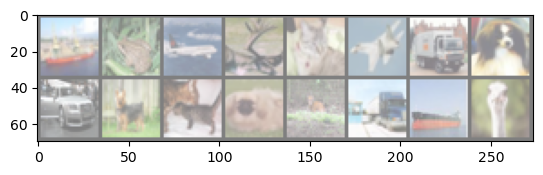

In [22]:
# get some random training images
dataiter = iter(testloader)
images = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:16]))

8.**Evaluate your final model on the test set**

Submit `predictions.npy` to Gradescope to see your model's performance on the test set.

In [23]:
# run inference on the test set
predictions = run_secret_test(testloader, net, IS_GPU)
# save predictions
predictions = np.asarray(predictions)
np.save("Q1_label_predictions.npy", predictions)

#**Q2: Surface normal estimation**

Download the data (taskonomy_resize_128_public.zip) from google drive using this link (https://drive.google.com/file/d/1EhaGeojCBgoYtsdilTbGd81-95VSgmAP/view?usp=sharing) and upload it to colab.




In [24]:
!unzip -qqo taskonomy_resize_128_public.zip

In [25]:
import glob
import os
import numpy as np
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import models
from torchvision.transforms import ToTensor, Normalize

In [26]:
# global variable
device = torch.device("cuda:0")

In [27]:
class NormalDataset(data.Dataset):
    """
    Data loader for the Suface Normal Dataset. If data loading is a bottleneck,
    you may want to optimize this in for faster training. Possibilities include
    pre-loading all images and annotations into memory before training, so as
    to limit delays due to disk reads.
    """
    def __init__(self, split="train", data_dir="./taskonomy_resize_128_public"):
        assert(split in ["train", "val"])
        split2name = {
            "train": "allensville",
            "val": "beechwood",
        }
        self.img_dir = os.path.join(data_dir, split2name[split] + "_rgb")
        self.gt_dir = os.path.join(data_dir, split2name[split] + "_normal")

        self.split = split
        self.filenames = [
            os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*.png")
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        img = Image.open(os.path.join(self.img_dir, filename) + ".png")
        img = np.asarray(img).copy()
        gt = Image.open(os.path.join(self.gt_dir, filename.replace("_rgb", "_normal")) + ".png")
        gt = np.asarray(gt)

        # from rgb image to surface normal
        gt = gt.astype(np.float32) / 255
        gt = torch.Tensor(np.asarray(gt).copy()).permute((2, 0, 1))
        mask = self.build_mask(gt).to(torch.float)

        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)

        # normalize gt
        gt = gt * 2 - 1

        return img.contiguous(), gt, mask.sum(dim=0) > 0

    @staticmethod
    def build_mask(target, val=0.502, tol=1e-3):
        target = target.unsqueeze(0)
        if target.shape[1] == 1:
            mask = ((target >= val - tol) & (target <= val + tol))
            mask = F.conv2d(mask.float(), torch.ones(1, 1, 5, 5, device=mask.device), padding=2) != 0
            return (~mask).expand_as(target).squeeze(0)

        mask1 = (target[:, 0, :, :] >= val - tol) & (target[:, 0, :, :] <= val + tol)
        mask2 = (target[:, 1, :, :] >= val - tol) & (target[:, 1, :, :] <= val + tol)
        mask3 = (target[:, 2, :, :] >= val - tol) & (target[:, 2, :, :] <= val + tol)
        mask = (mask1 & mask2 & mask3).unsqueeze(1)
        mask = F.conv2d(mask.float(), torch.ones(1, 1, 5, 5, device=mask.device), padding=2) != 0
        return (~mask).expand_as(target).squeeze(0)

In [28]:
##########
#TODO: design your own network here. The expectation is to write from scratch. But it's okay to get some inspiration
#from conference paper. The bottom line is that you will not just copy code from other repo
##########
class MyModel(nn.Module):
   def __init__(self):
       super(MyModel, self).__init__()
       
       resnet = models.resnet18(pretrained=True)
       
       self.conv1 = resnet.conv1
       self.bn1 = resnet.bn1
       self.relu = resnet.relu
       self.maxpool = resnet.maxpool
       self.layer1 = resnet.layer1
       self.layer2 = resnet.layer2
       self.layer3 = resnet.layer3
       self.layer4 = resnet.layer4
       
       self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
       self.bn4 = nn.BatchNorm2d(256)
       
       self.upconv3 = nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1, bias=False)
       self.bn3 = nn.BatchNorm2d(128)
       
       self.upconv2 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1, bias=False)
       self.bn2 = nn.BatchNorm2d(64)
       
       self.upconv1 = nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=1, bias=False)
       self.bn1_up = nn.BatchNorm2d(32)
       
       self.upconv0 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False)
       self.bn0 = nn.BatchNorm2d(16)
       
       self.final_conv = nn.Conv2d(16, 3, kernel_size=3, padding=1)
   
   def forward(self, x):
       x0 = self.conv1(x)
       x0 = self.bn1(x0)
       x0 = self.relu(x0)
       
       x1 = self.maxpool(x0)
       x1 = self.layer1(x1)
       
       x2 = self.layer2(x1)
       x3 = self.layer3(x2)
       x4 = self.layer4(x3)
       
       d4 = self.relu(self.bn4(self.upconv4(x4)))
       d4 = torch.cat([d4, x3], dim=1)
       
       d3 = self.relu(self.bn3(self.upconv3(d4)))
       d3 = torch.cat([d3, x2], dim=1)
       
       d2 = self.relu(self.bn2(self.upconv2(d3)))
       d2 = torch.cat([d2, x1], dim=1)
       
       d1 = self.relu(self.bn1_up(self.upconv1(d2)))
       
       d0 = self.relu(self.bn0(self.upconv0(d1)))
       
       output = self.final_conv(d0)
       
       return F.normalize(output, p=2, dim=1)



In [29]:
##########
#TODO: define your loss function here
##########
class MyCriterion(nn.Module):
    def __init__(self):
        super(MyCriterion, self).__init__()
        
    def forward(self, prediction, target, mask):
        # Add a small epsilon to avoid division by zero
        prediction_normalized = F.normalize(prediction, p=2, dim=1, eps=1e-8)
        target_normalized = F.normalize(target, p=2, dim=1, eps=1e-8)
        
        # Calculate cosine similarity
        cos_sim = torch.sum(prediction_normalized * target_normalized, dim=1)
        
        # Clamp the values with a small margin for numerical stability
        cos_sim = torch.clamp(cos_sim, -0.999999, 0.999999)
        
        # L1 loss instead of directly using acos
        loss = 1 - cos_sim
        
        # Apply mask
        masked_loss = loss[mask]
        
        return masked_loss.mean()


In [30]:
def simple_train(model, criterion, optimizer, train_dataloader, epoch, **kwargs):
    model.train()
    
    running_loss = 0.0
    valid_batches = 0
    
    for i, (images, targets, masks) in enumerate(train_dataloader):
        images = images.to(device)
        targets = targets.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, targets, masks)
        
        # Check for NaN and skip problematic batches
        if torch.isnan(loss).item():
            print(f"Encountered NaN loss in batch {i}, skipping...")
            continue
            
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        valid_batches += 1
        
        if i % 20 == 19:
            avg_loss = running_loss / valid_batches if valid_batches > 0 else float('nan')
            print(f'Epoch: {epoch+1}, Batch: {i+1}, Loss: {avg_loss:.4f}')
            running_loss = 0.0
            valid_batches = 0
    
    return model


In [31]:
########################################################################
# TODO: Implement your training cycles, make sure you evaluate on validation
# dataset and compute evaluation metrics every so often.
# You may also want to save models that perform well.

model = MyModel().to(device)
criterion = MyCriterion().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

train_dataset = NormalDataset(split='train')
train_dataloader = data.DataLoader(train_dataset, batch_size=8,
                                 shuffle=True, num_workers=2,
                                 drop_last=True)

val_dataset = NormalDataset(split='val')
val_dataloader = data.DataLoader(val_dataset, batch_size=8,
                               shuffle=False, num_workers=2)

num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
   model = simple_train(model, criterion, optimizer, train_dataloader, epoch)
   
   model.eval()
   val_loss = 0.0
   all_angular_errors = []
   
   with torch.no_grad():
       for images, targets, masks in val_dataloader:
           images = images.to(device)
           targets = targets.to(device)
           masks = masks.to(device)
           
           outputs = model(images)
           loss = criterion(outputs, targets, masks)
           val_loss += loss.item()
           
           outputs_normalized = F.normalize(outputs, p=2, dim=1)
           targets_normalized = F.normalize(targets, p=2, dim=1)
           dot_product = torch.sum(outputs_normalized * targets_normalized, dim=1)
           dot_product = torch.clamp(dot_product, -1.0, 1.0)
           angular_error = torch.acos(dot_product) * 180.0 / np.pi
           angular_error = angular_error[masks]
           all_angular_errors.append(angular_error.cpu())
   
   val_loss /= len(val_dataloader)
   all_angular_errors = torch.cat(all_angular_errors)
   mean_angular_error = all_angular_errors.mean().item()
   median_angular_error = all_angular_errors.median().item()
   
   acc_11_25 = (all_angular_errors < 11.25).float().mean().item() * 100
   acc_22_5 = (all_angular_errors < 22.5).float().mean().item() * 100
   acc_30 = (all_angular_errors < 30).float().mean().item() * 100
   
   print(f'Epoch {epoch+1}')
   print(f'Validation Loss: {val_loss:.4f}')
   print(f'Mean Angular Error: {mean_angular_error:.2f}°')
   print(f'Median Angular Error: {median_angular_error:.2f}°')
   print(f'Accuracy @ 11.25°: {acc_11_25:.2f}%')
   print(f'Accuracy @ 22.5°: {acc_22_5:.2f}%')
   print(f'Accuracy @ 30°: {acc_30:.2f}%')
   
   scheduler.step(val_loss)
   
   if val_loss < best_val_loss:
       best_val_loss = val_loss
       torch.save({
           'epoch': epoch,
           'model_state_dict': model.state_dict(),
           'optimizer_state_dict': optimizer.state_dict(),
           'loss': val_loss,
           'mean_angular_error': mean_angular_error,
           'median_angular_error': median_angular_error,
           'acc_11_25': acc_11_25,
           'acc_22_5': acc_22_5,
           'acc_30': acc_30
       }, 'best_normal_model.pth')
       print("Saved best model!")
   
   print('-' * 50)


/share/pkg.8/academic-ml/fall-2024/install/fall-2024-pyt/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.8/academic-ml/fall-2024/install/fall-2024-pyt/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1, Batch: 20, Loss: 0.7382
Epoch: 1, Batch: 40, Loss: 0.5857
Epoch 1
Validation Loss: 0.4732
Mean Angular Error: 54.28°
Median Angular Error: 50.10°
Accuracy @ 11.25°: 3.38%
Accuracy @ 22.5°: 12.98%
Accuracy @ 30°: 22.04%
Saved best model!
--------------------------------------------------
Epoch: 2, Batch: 20, Loss: 0.3901
Epoch: 2, Batch: 40, Loss: 0.3170
Epoch 2
Validation Loss: 0.3276
Mean Angular Error: 43.43°
Median Angular Error: 40.69°
Accuracy @ 11.25°: 6.02%
Accuracy @ 22.5°: 20.49%
Accuracy @ 30°: 32.37%
Saved best model!
--------------------------------------------------
Epoch: 3, Batch: 20, Loss: 0.2456
Epoch: 3, Batch: 40, Loss: 0.2162
Epoch 3
Validation Loss: 0.2717
Mean Angular Error: 39.09°
Median Angular Error: 36.94°
Accuracy @ 11.25°: 7.70%
Accuracy @ 22.5°: 24.55%
Accuracy @ 30°: 37.73%
Saved best model!
--------------------------------------------------
Epoch: 4, Batch: 20, Loss: 0.1778
Epoch: 4, Batch: 40, Loss: 0.1733
Epoch 4
Validation Loss: 0.2485
Mean A

# You do not need to change anything below

In [32]:
########################################################################
# Evaluate your result, and report
# 1. Mean angular error
# 2. Median angular error
# 3. Accuracy at 11.25 degree
# 4. Accuracy at 22.5 degree
# 5. Accuracy at 30 degree
# using provided `simple_predict` function.

def angle_error(prediction, target):
    prediction_error = torch.cosine_similarity(prediction, target)
    prediction_error = torch.clamp(prediction_error, min=-1.0, max=1.0)
    prediction_error = torch.acos(prediction_error) * 180.0 / np.pi
    return prediction_error

def simple_predict(split, model):
    model.eval()
    dataset = NormalDataset(split=split)
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False,
                                 num_workers=2, drop_last=False)
    gts, preds, losses = [], [], []
    total_normal_errors = None
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, gt, mask = batch
            img = img.to(device)
            gt = gt.to(device)
            mask = mask.to(device)

            pred = model(img)
            loss = (F.l1_loss(pred, gt, reduction="none") * mask.unsqueeze(1)).mean()

            gts.append((gt[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            losses.append(loss.item())

            angle_error_prediction = angle_error(pred, gt)
            angle_error_prediction = angle_error_prediction[mask > 0].view(-1)
            if total_normal_errors is None:
                total_normal_errors = angle_error_prediction.cpu().numpy()
            else:
                total_normal_errors = np.concatenate(
                    (total_normal_errors, angle_error_prediction.cpu().numpy())
                )

    return gts, preds, losses, total_normal_errors

val_gts, val_preds, val_losses, val_total_normal_errors = simple_predict('val', model)
print("Validation loss (L1):", np.mean(val_losses))
print("Validation metrics: Mean %.1f, Median %.1f, 11.25deg %.1f, 22.5deg %.1f, 30deg %.1f" % (
    np.average(val_total_normal_errors), np.median(val_total_normal_errors),
    np.sum(val_total_normal_errors < 11.25) / val_total_normal_errors.shape[0] * 100,
    np.sum(val_total_normal_errors < 22.5) / val_total_normal_errors.shape[0] * 100,
    np.sum(val_total_normal_errors < 30) / val_total_normal_errors.shape[0] * 100
))

# vis validation
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    ax.imshow(val_gts[idx])
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(val_preds[idx])
    ax.axis('off')
fig.tight_layout()
plt.savefig('vis_valset.pdf', format='pdf', bbox_inches='tight')

  0%|          | 0/200 [00:00<?, ?it/s]

Validation loss (L1): 0.2691164869442582
Validation metrics: Mean 33.9, Median 29.6, 11.25deg 16.9, 22.5deg 38.3, 30deg 50.6


In [36]:
# Visualization
# pick some of your favorite images and put them under `./data/normal_visualization/image`

class VisualizationDataset(data.Dataset):
    def __init__(self, image_dir="./taskonomy_resize_128_public", image_ext=".png"):
        self.img_dir = image_dir
        self.img_ext = image_ext

        self.img_dir = os.path.join(image_dir, "collierville_rgb")

        self.image_filenames = [
            os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*" + image_ext)
        ]
        self.image_filenames.sort()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        filename = self.image_filenames[index]
        img = Image.open(os.path.join(self.img_dir, filename) + self.img_ext)
        img = np.asarray(img).copy()
        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)

        return img.contiguous(), filename

def simple_vis(model):
    model.eval()
    dataset = VisualizationDataset(image_dir="./taskonomy_resize_128_public")
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False,
                                 num_workers=2, drop_last=False)
    imgs, preds = [], []

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, _ = batch
            img = img.to(device)

            pred = model(img)
            imgs.append(
                std * img[0].permute((1, 2, 0)).cpu().numpy() + mean
            )
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)

    return imgs, preds

imgs, preds = simple_vis(model)
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    ax.imshow(imgs[idx])
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(preds[idx])
    ax.axis('off')
fig.tight_layout()
plt.savefig('CS585_visualization.pdf', format='pdf', bbox_inches='tight')

  0%|          | 0/200 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.7418136649970393e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


In [39]:
# Visualization
# pick some of your favorite images and put them under `./data/normal_visualization/image`

class VisualizationDataset(data.Dataset):
    def __init__(self, image_dir="./taskonomy_resize_128_public", image_ext=".png"):
        self.img_dir = image_dir
        self.img_ext = image_ext

        self.img_dir = os.path.join(image_dir, "collierville_rgb")

        self.image_filenames = [
            os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*" + image_ext)
        ]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        filename = self.image_filenames[index]
        img = Image.open(os.path.join(self.img_dir, filename) + self.img_ext)
        img = np.asarray(img).copy()
        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)

        return img.contiguous(), filename

def simple_vis(model):
    model.eval()
    dataset = VisualizationDataset(image_dir="./taskonomy_resize_128_public")
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False,
                                 num_workers=2, drop_last=False)
    imgs, preds = [], []

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, _ = batch
            img = img.to(device)

            pred = model(img)
            imgs.append(
                std * img[0].permute((1, 2, 0)).cpu().numpy() + mean
            )
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)

    return imgs, preds

imgs, preds = simple_vis(model)
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    ax.imshow(imgs[idx])
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(preds[idx])
    ax.axis('off')
fig.tight_layout()
plt.savefig('q2_visualization.pdf', format='pdf', bbox_inches='tight')
   

  0%|          | 0/200 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [3.051757813121725e-08..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.7418136649970393e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000076293944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.7418136649970393e-09..1.0000000236034394].


In [40]:
# Test your model on the test set, submit the output to gradescope

from PIL import Image
import numpy as np

def simple_test(model, out_dir):
    model.eval()
    dataset = VisualizationDataset(image_dir="./taskonomy_resize_128_public")
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False,
                                 num_workers=2, drop_last=False)

    saved_predictions = []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, filename = batch
            img = img.to(device)

            pred = model(img)
            saved_predictions.append(pred.cpu())

        saved_predictions = torch.cat(saved_predictions, dim=0)
        return saved_predictions

out_dir = "Q2_normal_predictions"
saved_predictions = simple_test(model, out_dir)
np.save('./Q2_surface_predictions.npy', saved_predictions)

  0%|          | 0/200 [00:00<?, ?it/s]